### EDA for moex pump and dump cases


#### Imports 


In [7]:
import pandas as pd 
import numpy as np
import datetime 
import os 
from isswrapper.util.helpers import read_parquet_into_dataframe
from ydata_profiling import ProfileReport
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
import matplotlib.pyplot as plt
from pnd_moex.general.plots import anomaly_plot
from pnd_moex.general.general import anomaly_detect
from pnd_moex.util.other import find_all_sequences

In [8]:
# loading data
current_path = os.getcwd()
project_path = os.path.dirname(current_path)
datasets_folder_path = os.path.join(project_path, 'datasets')
# news 
pnd_token_date_df = read_parquet_into_dataframe(os.path.join(datasets_folder_path, "pnd_token_date.parquet"))
# all time series
ts_df = read_parquet_into_dataframe(os.path.join(datasets_folder_path, "time_series_securities_pnd.parquet"))
print(ts_df.shape)
ts_df.sample(5)

(134205, 24)


,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,WAPRICE,CLOSE,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION,CURRENCYID,TRENDCLSPR,currencyid
1457,TQBR,2020-03-23,ЭнергияРКК,RKKE,10.0,153140.0,4440.00000,4310.0000,4440.0000,4310.00000,4380.000000,4310.000000,35.0,NaN,4340.00000,4310.0000,0.0,529000.0,0.0,NaN,3,SUR,-3.79,RUB
215,TQBR,2015-04-17,ТГК-14,TGKN,40.0,179035.0,0.00151,0.0015,0.0016,0.00153,0.001545,0.001555,116000000.0,NaN,0.00153,NaN,0.0,526250.0,0.0,NaN,3,SUR,1.97,RUB
458,TQBR,2016-04-06,СОЛЛЕРС,SVAV,34.0,305950.0,409.00000,406.0000,409.0000,409.00000,408.000000,409.000000,750.0,NaN,407.00000,409.0000,0.0,524580.0,0.0,NaN,3,SUR,0.74,RUB
2303,TQBR,2023-07-27,КамчатЭ ап,KCHEP,188.0,4154270.0,1.07000,1.0150,1.1100,1.03500,1.071000,1.035000,3880000.0,1.0710,1.07100,NaN,4154270.0,4154270.0,NaN,0.0,3,SUR,1.37,RUB
344,TQPI,2022-01-10,ДагСб ао,DASB,3242.0,14306135.7,0.22980,0.2120,0.2400,0.21530,0.224300,0.215300,63786000.0,0.2243,0.22430,0.2153,14306135.7,14306135.7,14306135.7,0.0,3,SUR,-4.73,RUB


In [9]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134205 entries, 0 to 2325
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   BOARDID                  134205 non-null  object 
 1   TRADEDATE                134205 non-null  object 
 2   SHORTNAME                134205 non-null  object 
 3   SECID                    134205 non-null  object 
 4   NUMTRADES                134205 non-null  float64
 5   VALUE                    134205 non-null  float64
 6   OPEN                     108075 non-null  float64
 7   LOW                      108075 non-null  float64
 8   HIGH                     108075 non-null  float64
 9   LEGALCLOSEPRICE          134024 non-null  float64
 10  WAPRICE                  108644 non-null  float64
 11  CLOSE                    108075 non-null  float64
 12  VOLUME                   134122 non-null  float64
 13  MARKETPRICE2             42177 non-null   float64
 14  MARKETPRICE

In [10]:
ts_df.columns

Index(['BOARDID', 'TRADEDATE', 'SHORTNAME', 'SECID', 'NUMTRADES', 'VALUE',
       'OPEN', 'LOW', 'HIGH', 'LEGALCLOSEPRICE', 'WAPRICE', 'CLOSE', 'VOLUME',
       'MARKETPRICE2', 'MARKETPRICE3', 'ADMITTEDQUOTE', 'MP2VALTRD',
       'MARKETPRICE3TRADESVALUE', 'ADMITTEDVALUE', 'WAVAL', 'TRADINGSESSION',
       'CURRENCYID', 'TRENDCLSPR', 'currencyid'],
      dtype='object')

 - BOARDID: Identifier for the trading board where the security is listed.
 - TRADEDATE: Date of the trading session.
 - SHORTNAME: Short name or abbreviation for the security.
 - SECID: Security identifier, unique symbol.
 - NUMTRADES: Number of trades executed during the trading session.
 - VALUE: Total value of trades executed during the trading session.
 - OPEN: Opening price of the security for the trading session.
 - LOW: Lowest price of the security during the trading session.
 - HIGH: Highest price of the security during the trading session.
 - LEGALCLOSEPRICE: Official closing price of the security for the trading session.
 - WAPRICE (Weighted Average Price): The average price of trades, weighted by trade volume.
 - CLOSE: Closing price of the security for the trading session.
 - VOLUME: Total trading volume (number of shares or contracts) during the trading session.
 - MARKETPRICE2 and MARKETPRICE3: Market prices used for trading analysis or purposes.
 - ADMITTEDQUOTE: A possibly related value associated with permissible quotes or prices.
 - MP2VALTRD (Market Price to Value Traded): Ratio of market price to the total value traded.
 - MARKETPRICE3TRADESVALUE: Value related to market price and traded value, specific context may vary.
 - ADMITTEDVALUE: Value associated with permissible trading.
 - WAVAL: Potentially related to weighted average values.
 - TRADINGSESSION: Description of the trading session or time period.
 - CURRENCYID: Identifier for the currency used in trading.
 - TRENDCLSPR: Trend closing price, possibly used in technical analysis.

[datetime.datetime(2022, 4, 8, 15, 41)]


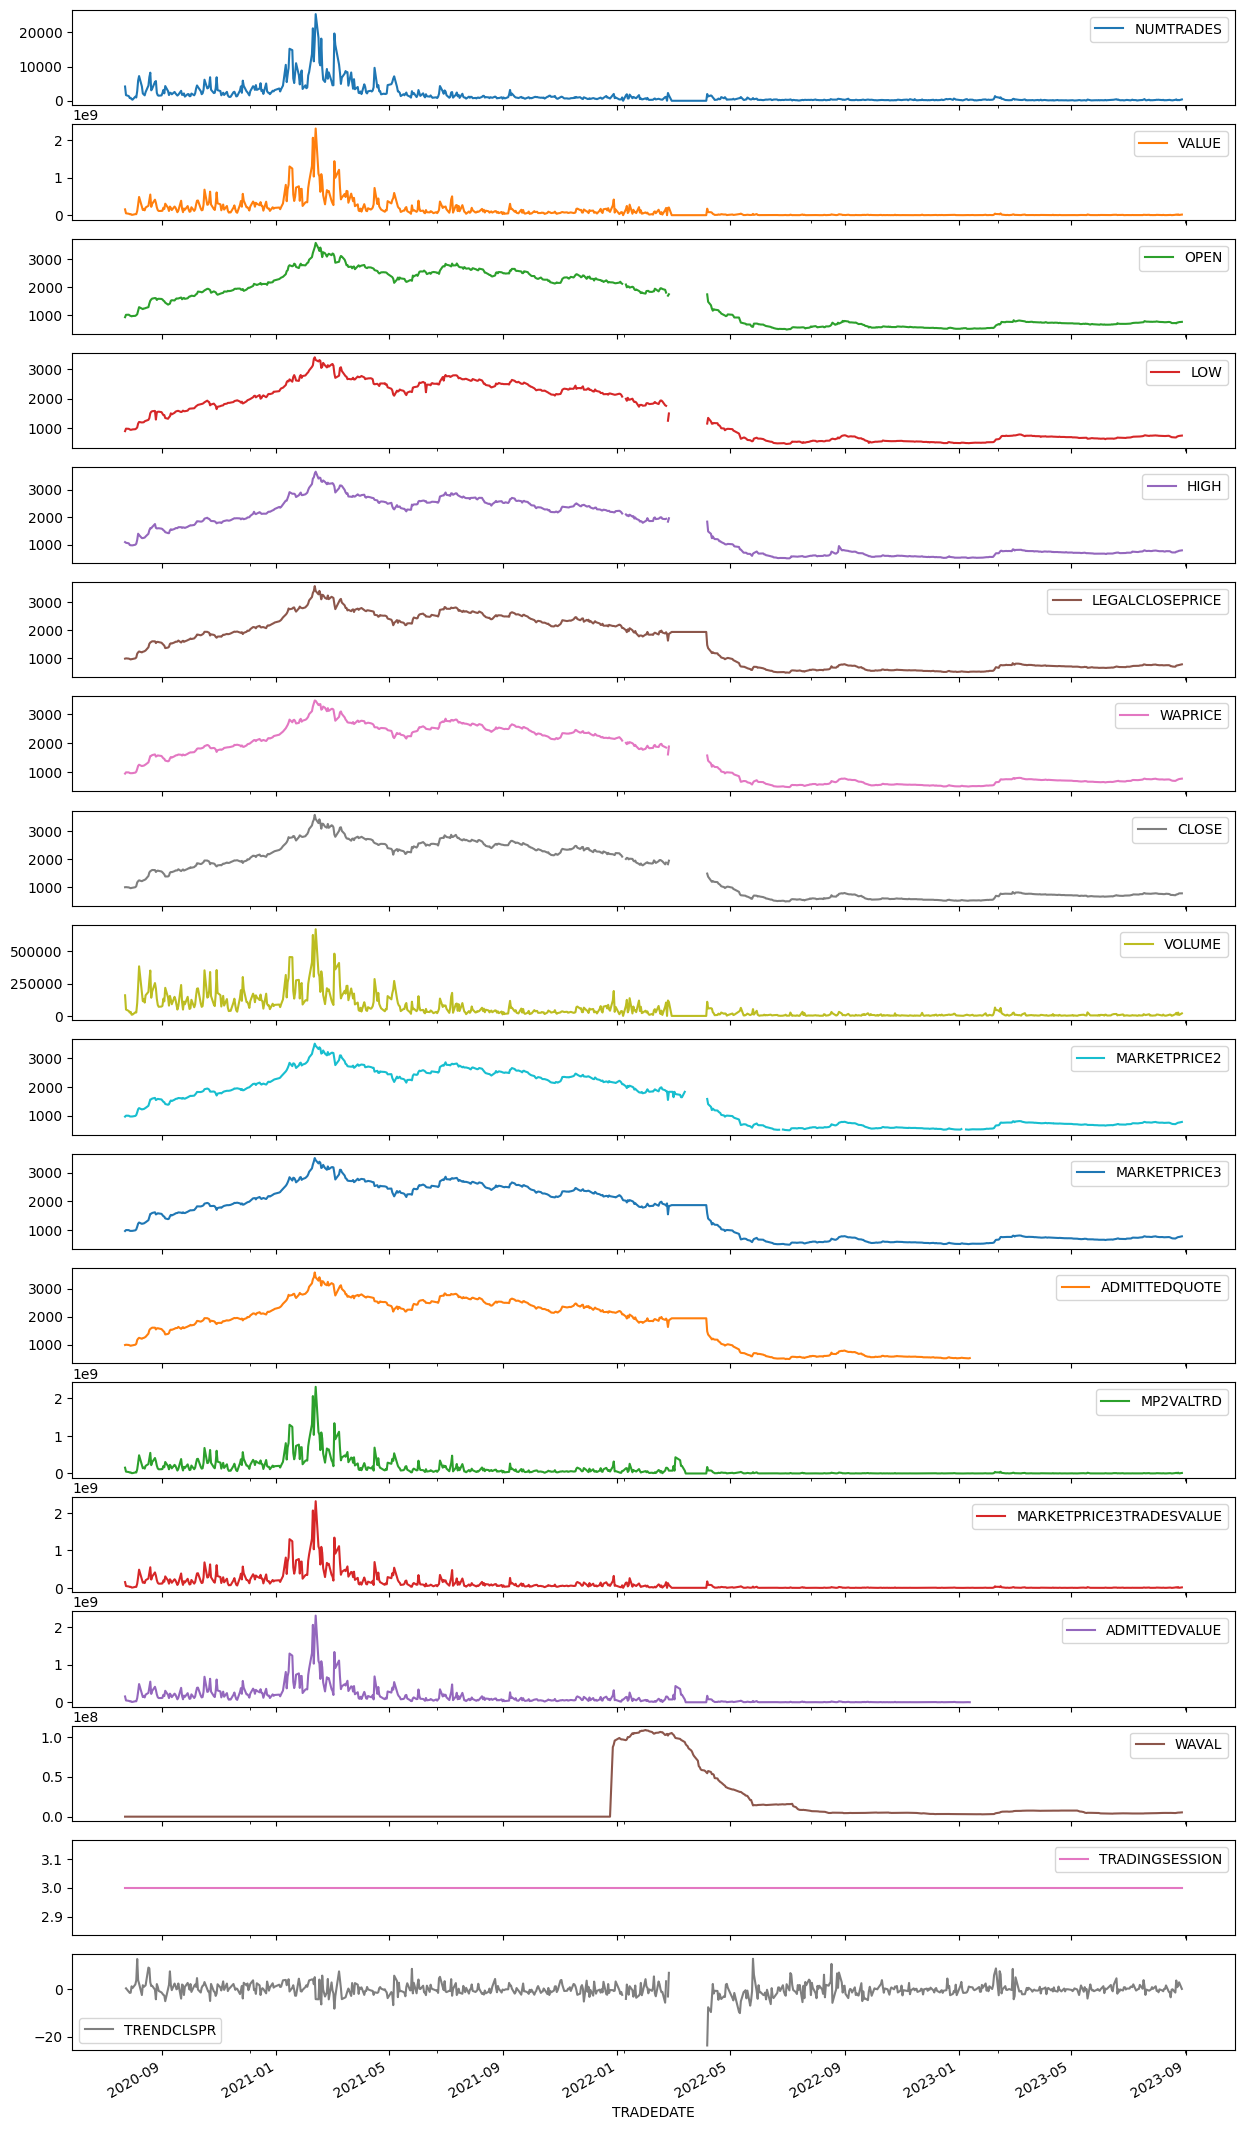

In [11]:
# chosing token
token = np.random.choice(pnd_token_date_df["token"].unique())
# token = "ASSB"
# selecting data
sec_df = ts_df[ts_df["SECID"]==token]
# making proper index
sec_df = sec_df.sort_values("TRADEDATE")
sec_df.index = pd.to_datetime(sec_df["TRADEDATE"])
# news
n_list = pnd_token_date_df[pnd_token_date_df["token"]==token]["p_date"].iloc[0].tolist()
print(n_list)

ax = sec_df.plot(subplots=True, figsize=(15, 30))


Some variables appear to be very similar, while others seem uninformative. Let's examine them more closely

In [12]:
ts_df["TRADINGSESSION"].unique()

array([3], dtype=int64)

We drop the trading session column because it remains constant for all records.

Next lets examine WAVAL column

In [13]:
waval_uniq = ts_df.groupby("SECID")["WAVAL"].unique().apply(lambda x: len(x))
print(waval_uniq.value_counts())
print(f'All rerords len {ts_df.shape[0]} \nWaval is not equal to zero len {ts_df[ts_df["WAVAL"]!=0]["WAVAL"].notna().sum()}' )
print(f'Non zero values in WAVAL column is {ts_df[ts_df["WAVAL"]!=0]["WAVAL"].notna().sum()*100/ts_df.shape[0]:.2f}%')

WAVAL
2      55
1      14
124     2
422     1
Name: count, dtype: int64
All rerords len 134205 
Waval is not equal to zero len 1585
Non zero values in WAVAL column is 1.18%


In [14]:
waval_uniq[waval_uniq>3].index

Index(['FXRW', 'FXWO', 'RU000A101NK4'], dtype='object', name='SECID')

So for almost all securities WAVAL remains constant, but there are 3 of them that are not. Let's plot them and try to find out something interesting

Text(0.5, 0.98, 'Securities with non zero WAVAL')

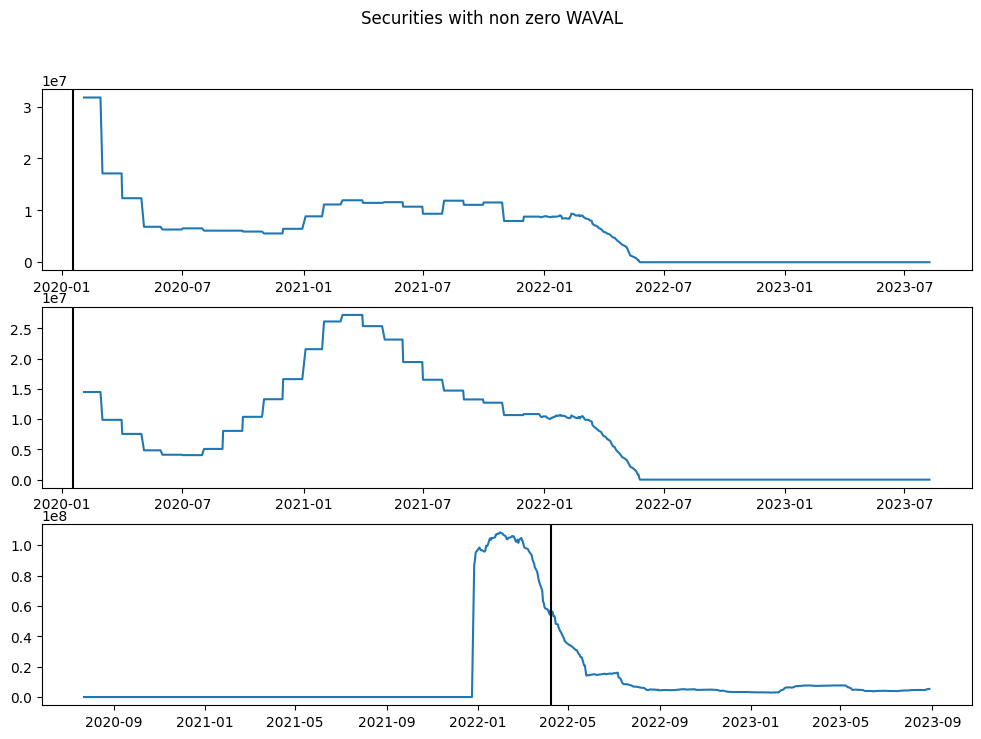

In [15]:
# anomalous tokens
ano_token = ['FXRW', 'FXWO', 'RU000A101NK4']
wv_df = ts_df[ts_df["SECID"].isin(ano_token)]
# making proper index
wv_df = wv_df.sort_values("TRADEDATE")
wv_df.index = pd.to_datetime(wv_df["TRADEDATE"])
# news
groups = wv_df.groupby("SECID")["WAVAL"]
fig, ax = plt.subplots(figsize=(12, 8), nrows=3, ncols=1)
for idx, (name, group) in enumerate(groups):
    n_list = pnd_token_date_df[pnd_token_date_df["token"]==ano_token[idx]]["p_date"].iloc[0].tolist()
    ax[idx].plot(group)
    for news in n_list:
        ax[idx].axvline(x=news, color="#000000")
fig.suptitle("Securities with non zero WAVAL")

It's difficult to determine. For most securities in our dataset, the 'WAVAL' variable is 0 or NaN. However, these specific three tokens have shown some interesting results.

In all three cases, when news appears, the WAVAL value is already decreasing. As we can see from the third plot, there is a peak before the news appears. Theoretically, it could be a good indicator of a pump. However, because we have less than 1.2% of non-zero values for this indicator, I have decided to drop it.

When it comes to categorical variables, we certainly don't need BOARDID, SHORTNAME, and CURRENCYID.

The first two cannot provide us with any valuable information, and the last one is insufficient since 'currencyid' serves the same purpose but is better because it is a symbol, not a numerical ID.

In [16]:
clear_ts_df = ts_df.drop(columns=["BOARDID", "SHORTNAME","CURRENCYID", "TRADINGSESSION", "WAVAL"])
print(clear_ts_df.shape)
clear_ts_df['TRADEDATE'] = clear_ts_df['TRADEDATE'].apply(lambda x: datetime.datetime.combine(x, datetime.time()))
clear_ts_df['TRADEDATE'] = pd.to_datetime(clear_ts_df['TRADEDATE']).to_numpy()

clear_ts_df.sample(5)

(134205, 19)


,TRADEDATE,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,WAPRICE,CLOSE,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,TRENDCLSPR,currencyid
309,2022-01-28,RLMNP,176.0,160675.4,10.580,9.880,10.7200,9.9000,10.1800,9.9000,15790.0,NaN,10.620,9.9000,0.0,500148.0,0.0,-3.88,RUB
16,2020-07-16,MSST,362.0,861081.6,1.517,1.517,1.5820,1.5800,1.5500,1.5800,555400.0,1.55,1.550,1.5800,861081.6,861081.6,861081.6,3.00,RUB
1809,2021-08-12,MRKS,17.0,75670.0,0.290,0.290,0.3165,0.3055,0.3025,0.3065,250000.0,NaN,0.304,0.3055,0.0,501660.0,0.0,1.83,RUB
2112,2022-10-24,KTSB,38.0,47012.0,0.470,0.466,0.4900,0.4760,0.4740,0.4760,99000.0,NaN,0.478,0.4760,0.0,507156.0,0.0,0.42,RUB
2056,2022-08-05,RTSB,11.0,24052.0,0.536,0.534,0.5400,0.5360,0.5340,0.5360,45000.0,NaN,0.538,0.5360,0.0,502404.0,0.0,-1.11,RUB


As we saw earlier, some functions are very similar, which might not be good for our model. Let's perform EDA using 'ydata-profiling' for the time series to determine if some values are excessive.

In [17]:
# chosing token
token = np.random.choice(pnd_token_date_df["token"].unique())
# selecting data
sec_df = clear_ts_df[clear_ts_df["SECID"]==token]
# making proper index
sec_df = sec_df.sort_values("TRADEDATE")
sec_df.index = pd.to_datetime(sec_df["TRADEDATE"])
# news
n_list = pnd_token_date_df[pnd_token_date_df["token"]==token]["p_date"].iloc[0].tolist()
print(n_list)


[datetime.datetime(2021, 1, 14, 20, 17)]


In [ ]:
profile = ProfileReport(sec_df.drop(columns=["TRADEDATE", "SECID", "currencyid"]), tsmode=True)
profile.to_notebook_iframe()

As expected, there are still many highly correlated columns. We should consider addressing this issue later. Ultimately, it may be sufficient to use just one or two columns.

But what about anomalies?


In [18]:
# anomalies
a_df = anomaly_detect(sec_df["CLOSE"], True,True,True )
anomaly_plot(sec_df, a_df, n_list)


And what about if we try to find anomaies using other columns?

In [19]:
# anomalies
a_df = anomaly_detect(sec_df["NUMTRADES"], True,True,True)
anomaly_plot(sec_df, a_df, n_list)


c:\Users\Miqasa\OneDrive\Документы\ds_projs\other\pnd_detector\.venv\Lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract



In [21]:
# anomalies
a_df = anomaly_detect(sec_df["VOLUME"], True,True,True)
anomaly_plot(sec_df, a_df, n_list)


c:\Users\Miqasa\OneDrive\Документы\ds_projs\other\pnd_detector\.venv\Lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract



In [20]:
# anomalies
a_df = anomaly_detect(sec_df["VALUE"], True,True,True)
anomaly_plot(sec_df, a_df, n_list)


c:\Users\Miqasa\OneDrive\Документы\ds_projs\other\pnd_detector\.venv\Lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract



In [22]:
# anomalies
a_df = anomaly_detect(sec_df["ADMITTEDQUOTE"], True,True,True)
anomaly_plot(sec_df, a_df, n_list)


WHoa!